# Training a Variational Auto-Encoder

This guide will give a quick guide on training a variational auto-encoder (VAE) in torchbearer. We will use the VAE example from the pytorch examples [here](https://github.com/pytorch/examples/tree/master/vae). 

We will compare the implementations of a standard VAE and one that uses torchbearers persistant state.

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU with

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Install Torchbearer

First we install torchbearer if needed.

In [1]:
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer
    
print(torchbearer.__version__)

0.3.2


## Defining the Models

First, we define the standard PyTorch VAE. 

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3)).view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

Now lets modify this to use torchbearers state by overriding the forward method. Here, we define some state keys with the [`state_key` method](https://torchbearer.readthedocs.io/en/latest/code/main.html#torchbearer.state.state_key) which will store our `MU` and `LOGVAR`.

In [3]:
import torchbearer

# Define state keys for storing things in torchbearers state
MU, LOGVAR = torchbearer.state_key('mu'), torchbearer.state_key('logvar')


class TorchbearerVAE(VAE):
    def forward(self, x, state):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        state[MU], state[LOGVAR] = mu, logvar
        return self.decode(z)

There is very llittle difference between these models except that for torchbearers VAE we store the mean and log-variance in state instead of outputing them. This allows us to access them from within callbacks as well as for the loss. 

## Defining the Loss Functions

Lets now look at loss functions for these models. First we see the standard VAE loss function. 

In [4]:
def binary_cross_entropy(y_pred, y_true):
    BCE = F.binary_cross_entropy(y_pred.view(-1, 784), y_true.view(-1, 784), reduction='sum')
    return BCE
  
def kld(mu, logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return KLD

def loss_function(y_pred, y_true):
    recon_x, mu, logvar = y_pred
    x = y_true

    BCE = bce_loss(recon_x, x)

    KLD = kld_Loss(mu, logvar)

    return BCE + KLD

In Torchbearer we have a couple options for how to define this loss. Since Torchbearer loss functions can either be a funciton of (y_pred, y_true) or (state), we could actually use the standard loss function (taking state) and grabbing the mean and log-variance from state.  
Instead we shall showcase the "add_to_loss" callback decorator to add the KL loss, alongside a base reconstruciton loss. 

In [5]:
main_loss = binary_cross_entropy

@torchbearer.callbacks.add_to_loss
def add_kld_loss_callback(state):
    KLD = kld(state[MU], state[LOGVAR])
    return KLD

## Data

Both these models need data in the same format, so lets define out data now.  We create a simple dataset class to wrap the PyTorch MNIST dataset so that we can replace the target (usually a clas label) with the input image. As in the [quickstart example](https://torchbearer.readthedocs.io/en/latest/examples/notebooks.html#notebooks-list), we use the [`DatasetValidationSplitter`](https://torchbearer.readthedocs.io/en/latest/code/main.html#torchbearer.cv_utils.DatasetValidationSplitter) here to obtain a validation set.

In [6]:
import torch
from torch.utils.data.dataset import Dataset
import torchvision
from torchvision import transforms

from torchbearer.cv_utils import DatasetValidationSplitter

class AutoEncoderMNIST(Dataset):
    def __init__(self, mnist_dataset):
        super().__init__()
        self.mnist_dataset = mnist_dataset

    def __getitem__(self, index):
        character, label = self.mnist_dataset.__getitem__(index)
        return character, character

    def __len__(self):
        return len(self.mnist_dataset)


BATCH_SIZE = 128

transform = transforms.Compose([transforms.ToTensor()])

# Define standard classification mnist dataset with random validation set

dataset = torchvision.datasets.MNIST('./data/mnist', train=True, download=True, transform=transform)
splitter = DatasetValidationSplitter(len(dataset), 0.1)
basetrainset = splitter.get_train_dataset(dataset)
basevalset = splitter.get_val_dataset(dataset)
basetestset = torchvision.datasets.MNIST('./data/mnist', train=False, download=True, transform=transform)

# Wrap base classification mnist dataset to return the image as the target

trainset = AutoEncoderMNIST(basetrainset)

valset = AutoEncoderMNIST(basevalset)

testset = AutoEncoderMNIST(basetestset)

traingen = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

valgen = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

testgen = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

## Visualising the Model

For auto-encoding problems it is often useful to visualise the reconstructions. We can do this in torchbearer by using the [`MakeGrid` callback](https://torchbearer.readthedocs.io/en/latest/code/callbacks.html#torchbearer.callbacks.imaging.imaging.MakeGrid), from the [`imaging` sub-package](https://torchbearer.readthedocs.io/en/latest/code/callbacks.html#module-torchbearer.callbacks.imaging). This is an [`ImagingCallback`](https://torchbearer.readthedocs.io/en/latest/code/callbacks.html#torchbearer.callbacks.imaging.imaging.ImagingCallback) which uses torchvisions [save_image](https://pytorch.org/docs/stable/torchvision/utils.html?highlight=save#torchvision.utils.save_image) to make a grid of images.

In [7]:
from torchbearer.callbacks import imaging

targets = imaging.MakeGrid(torchbearer.TARGET, num_images=64, nrow=8)
targets = targets.on_test().to_pyplot().to_file('targets.png')

predictions = imaging.MakeGrid(torchbearer.PREDICTION, num_images=64, nrow=8)
predictions = predictions.on_test().to_pyplot().to_file('predictions.png')

In the above code we create two callbacks, one which makes a grid of target images, another which makes a grid of predictions. These will be saved to a file and plotted with pyplot.

## Training the Model

Now lets train the model. We shall skip training the standard PyTorch model since that is covered in the PyTorch examples. To train our Torchbearer model we first create a `Trial` and then call `run` on it. Along the way we add some metrics to be displayed and add our visualisation callback. **Note**: We set `verbose=1` here to mean that the progress bar should only tick for each epoch (rather than each batch, we creates a lot of output), this can be set at a trial level or for each call to `run` or `evaluate`.

In [8]:
import torch.optim as optim
from torchbearer import Trial

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = TorchbearerVAE()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
loss = binary_cross_entropy

trial = Trial(model, optimizer, main_loss, metrics=['acc', 'loss'],
                          callbacks=[add_kld_loss_callback, predictions, targets]).to(device)
trial.with_generators(train_generator=traingen, val_generator=valgen, test_generator=testgen)
_ = trial.run(epochs=10, verbose=1)

We now evaluate on the test data, and see how well our model performed

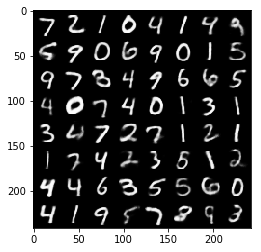

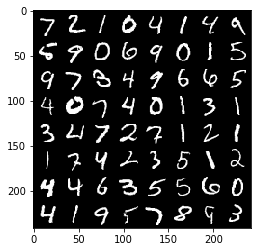

{'test_binary_acc': 0.9711461663246155, 'test_loss': 12219.810546875}

In [9]:
trial.evaluate(data_key=torchbearer.TEST_DATA)